In [1]:
import random
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import models
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_image(img):
    
    """Load and preprocess image."""

    x = cv.imread(img)
    x = cv.cvtColor(x, cv.COLOR_BGR2RGB)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    return x

def extract_label(img,df):
    
    find = df[df['ID'].str.match(img)]
    return find


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv.resize(cam, (W, H), cv.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def compute_gradcam(model, img, labels, selected_labels, df,
                    layer_name='top_bn'):
    
    preprocessed_input = load_image(img)
    predictions = model.predict(preprocessed_input)

    image = cv.imread(img)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    orig_label = extract_label(img,df)
    
    print("Original labels - ")
    print(tabulate(orig_label, headers='keys', tablefmt='psql'))
    print("")
    
    print("Predicted heatmaps - ")
    plt.figure(figsize=(15, 15))
    plt.subplot(151)

    j = 0
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={(predictions[0][i])*100:.2f} %")
            plt.axis('off')
            plt.imshow(image, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

In [3]:
labels = ['Epidural','Intraparenchymal','Intraventricular','Subarachnoid','Subdural']

df = pd.read_csv('RSNA.csv')
df = df.drop(df[df.Any == 0].index)
del df['Any']
df_train = df.iloc[:70000,:]
df_test = df.iloc[80002:,:]
df_train['ID'] = df_train['ID'].astype(str) + '.png'
df_test['ID'] = df_test['ID'].astype(str) + '.png'

def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1):

    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        rotation_range = 90,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        fill_mode='nearest', cval=0.0)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)
    
    return generator

def get_test_and_valid_generator(test_df, train_df, image_dir, x_col, y_cols, 
                                 sample_size=500, batch_size=16, seed=1):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="ID", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)


    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    return test_generator

IMAGE_DIR = "C:/Users/asarkar.NATICK-NT/ICH_dataset/ICH_png"
train_generator = get_train_generator(df_train, IMAGE_DIR, "ID", labels)
test_generator= get_test_and_valid_generator(df_test, df_train, IMAGE_DIR, "ID", labels)

getting train generator...
Found 70000 validated image filenames.
getting train and valid generators...
Found 70000 validated image filenames.
Found 17101 validated image filenames.


In [4]:
df_test.head(20)

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
555280,ID_d2a94c3b7.png,0,0,0,0,1
555282,ID_d2a98c0f1.png,0,0,1,1,0
555286,ID_d2a9d6921.png,0,1,0,1,0
555289,ID_d2a9f7ff7.png,0,0,0,0,1
555291,ID_d2aa11e41.png,0,0,0,1,1
555306,ID_d2ac2227a.png,0,0,1,0,0
555316,ID_d2acb14dd.png,0,0,1,0,0
555317,ID_d2acbce26.png,0,0,0,0,1
555323,ID_d2ad0ab29.png,0,0,0,1,0
555331,ID_d2add555c.png,0,0,1,0,0


In [5]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels==True,axis=0)/N
    negative_frequencies = np.sum(labels==False, axis=0)/N

    return positive_frequencies, negative_frequencies

In [6]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

In [7]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)
            

            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                     + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))   
            
        return loss
    
    return weighted_loss

In [8]:
model = tf.keras.models.load_model('EfficientNetB4_aug.h5',compile = False)
model.compile(optimizer='sgd', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_______________________________________________________________________________________

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


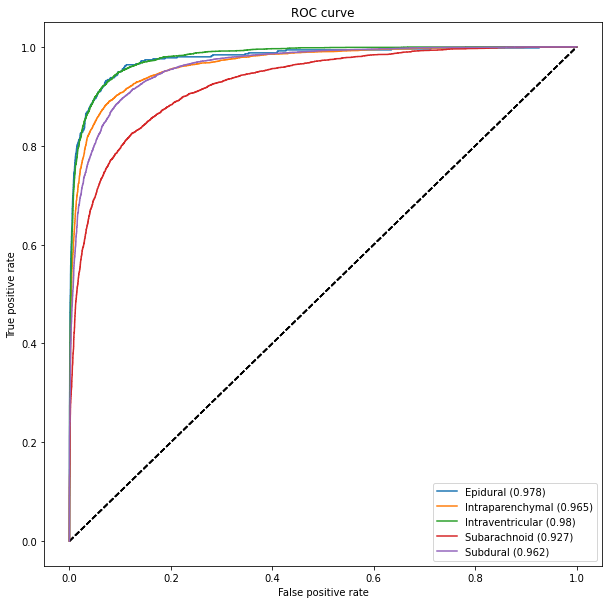

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


predicted_vals = model.predict(test_generator, steps = len(test_generator))

auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555280 | ID_d2a94c3b7.png |          0 |                  0 |                  0 |              0 |          1 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


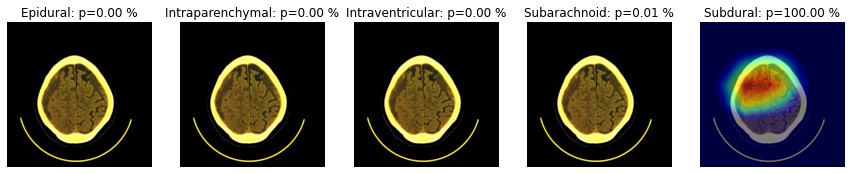

In [11]:
compute_gradcam(model, 'ID_d2a94c3b7.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555282 | ID_d2a98c0f1.png |          0 |                  0 |                  1 |              1 |          0 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


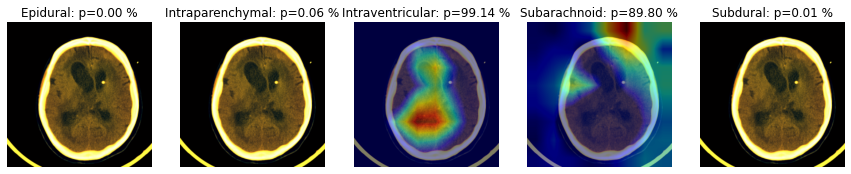

In [12]:
compute_gradcam(model, 'ID_d2a98c0f1.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555286 | ID_d2a9d6921.png |          0 |                  1 |                  0 |              1 |          0 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


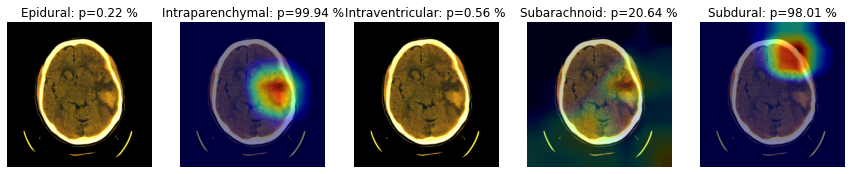

In [13]:
compute_gradcam(model, 'ID_d2a9d6921.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555289 | ID_d2a9f7ff7.png |          0 |                  0 |                  0 |              0 |          1 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


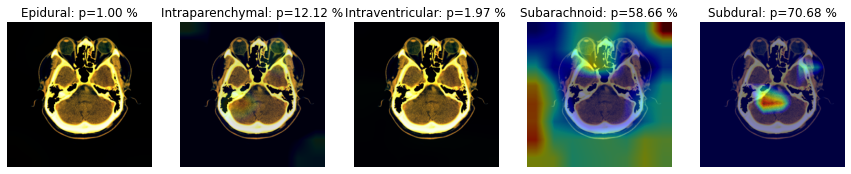

In [14]:
compute_gradcam(model, 'ID_d2a9f7ff7.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555291 | ID_d2aa11e41.png |          0 |                  0 |                  0 |              1 |          1 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


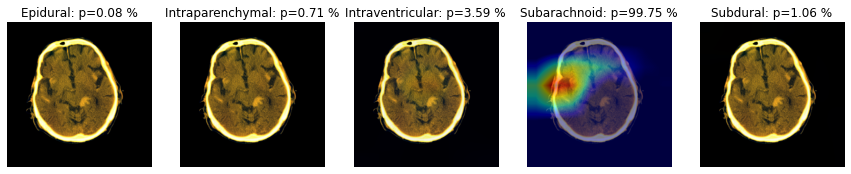

In [15]:
compute_gradcam(model, 'ID_d2aa11e41.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555410 | ID_d2b4f7619.png |          0 |                  1 |                  0 |              1 |          0 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


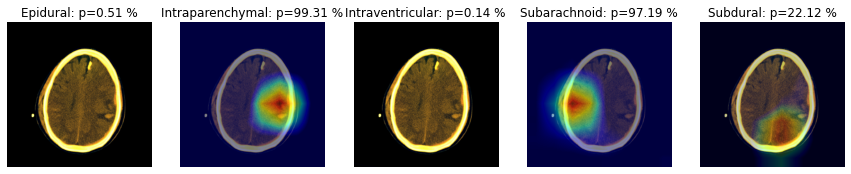

In [16]:
compute_gradcam(model, 'ID_d2b4f7619.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555393 | ID_d2b3b1e7d.png |          0 |                  1 |                  0 |              1 |          0 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


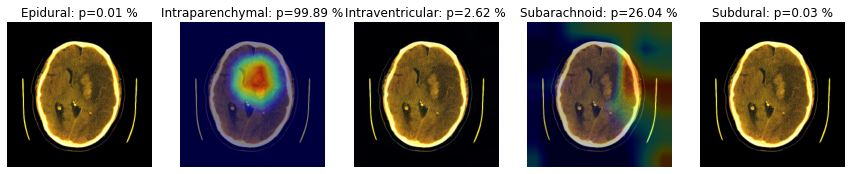

In [17]:
compute_gradcam(model, 'ID_d2b3b1e7d.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555376 | ID_d2b1bac16.png |          0 |                  1 |                  0 |              0 |          0 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


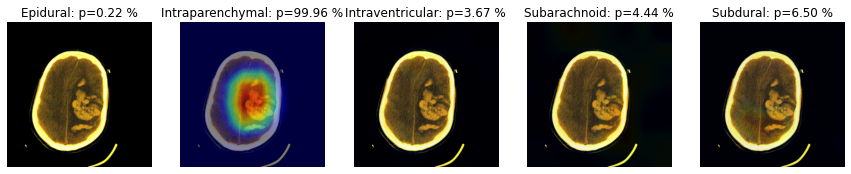

In [18]:
compute_gradcam(model, 'ID_d2b1bac16.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555323 | ID_d2ad0ab29.png |          0 |                  0 |                  0 |              1 |          0 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


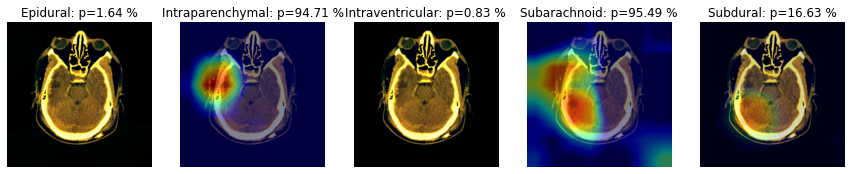

In [19]:
compute_gradcam(model, 'ID_d2ad0ab29.png', labels, labels, df_test)

Original labels - 
+--------+------------------+------------+--------------------+--------------------+----------------+------------+
|        | ID               |   Epidural |   Intraparenchymal |   Intraventricular |   Subarachnoid |   Subdural |
|--------+------------------+------------+--------------------+--------------------+----------------+------------|
| 555383 | ID_d2b29c03b.png |          1 |                  0 |                  0 |              0 |          1 |
+--------+------------------+------------+--------------------+--------------------+----------------+------------+

Predicted heatmaps - 


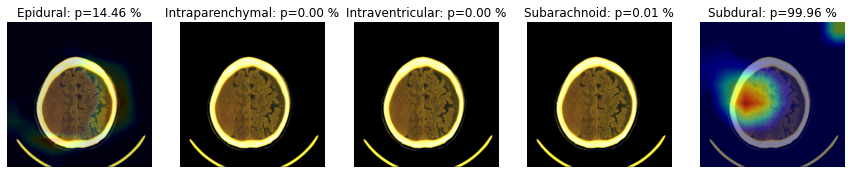

In [20]:
compute_gradcam(model, 'ID_d2b29c03b.png', labels, labels, df_test)